In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import csv
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


In [10]:
#data folder

log_path = '/Users/xslittlegrass/Downloads/driving_data/driving_log.csv'
data_folder = '/Users/xslittlegrass/Downloads/driving_data/'

#resized image dimension in training
img_rows = 16
img_cols = 32

#batch size and epoch
batch_size=128
nb_epoch=10

In [11]:
# readin log files

logs = []
with open(log_path,'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        logs.append(line)
log_labels = logs.pop(0)

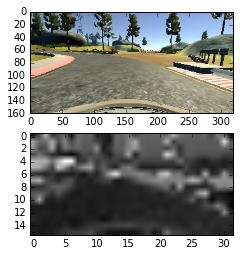

In [12]:
# image preprocessing, take only the S channel of HSV color space

img = plt.imread(data_folder + (logs[10][0]).strip())
img_processed = (cv2.cvtColor(cv2.resize(img,(32,16)), cv2.COLOR_RGB2HSV))[:,:,1]

plt.subplot(2,1,1)
plt.imshow(img)
plt.subplot(2,1,2)
plt.imshow(img_processed,cmap='gray')


In [13]:
def image_preprocessing(img):
    """preproccesing training data to keep only S channel in HSV color space, and resize to 16X32"""
    resized = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:,:,1],(img_cols,img_rows))
    return resized

**load and trim image**

In [14]:
def load_data(X,y,data_folder,delta=0.08):
    log_path = data_folder + 'driving_log.csv'
    logs = []
    with open(log_path,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)
    
    for i in range(len(logs)):
        img_path = logs[i][0]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_preprocessing(img))
        y.append(float(logs[i][3]))

    for i in range(len(logs)):
        img_path = logs[i][1]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_preprocessing(img))
        y.append(float(logs[i][3]) + delta)

    for i in range(len(logs)):
        img_path = logs[i][2]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_preprocessing(img))
        y.append(float(logs[i][3]) - delta)

In [15]:
data={}
data['features'] = []
data['labels'] = []

load_data(data['features'], data['labels'],data_folder,0.3)

In [16]:
X_train = np.array(data['features']).astype('float32')
y_train = np.array(data['labels']).astype('float32')

**add more data by reflection**

In [17]:
X_train = np.append(X_train,X_train[:,:,::-1],axis=0)
y_train = np.append(y_train,-y_train,axis=0)

**split training validation and test **

In [18]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

**reshape to the shape (None,16,32,1) **

In [19]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

**define model**

using a tiny model

In [20]:
	model = Sequential([
			Lambda(lambda x: x/127.5 - 1.,input_shape=(img_rows,img_cols,1)),
			Conv2D(2, 3, 3, border_mode='valid', input_shape=(img_rows,img_cols,1), activation='relu'),
			MaxPooling2D((4,4),(4,4),'valid'),
			Dropout(0.25),
			Flatten(),
			Dense(1)
		])

	model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 16, 32, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 14, 30, 2)     20          lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 3, 7, 2)       0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 3, 7, 2)       0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

**Train**

In [29]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train, y_train,batch_size=batch_size, nb_epoch=nb_epoch,verbose=1, validation_data=(X_val, y_val))

Train on 43394 samples, validate on 4822 samples
Epoch 1/10
43394/43394 [==============================] - 1s - loss: 0.1552 - val_loss: 0.0518
Epoch 2/10
43394/43394 [==============================] - 1s - loss: 0.0561 - val_loss: 0.0396
Epoch 3/10
43394/43394 [==============================] - 1s - loss: 0.0447 - val_loss: 0.0365
Epoch 4/10
43394/43394 [==============================] - 1s - loss: 0.0416 - val_loss: 0.0359
Epoch 5/10
43394/43394 [==============================] - 1s - loss: 0.0407 - val_loss: 0.0354
Epoch 6/10
43394/43394 [==============================] - 1s - loss: 0.0404 - val_loss: 0.0352
Epoch 7/10
43394/43394 [==============================] - 1s - loss: 0.0401 - val_loss: 0.0355
Epoch 8/10
43394/43394 [==============================] - 1s - loss: 0.0400 - val_loss: 0.0350
Epoch 9/10
43394/43394 [==============================] - 1s - loss: 0.0396 - val_loss: 0.0353
Epoch 10/10
43394/43394 [==============================] - 1s - loss: 0.0398 - val_loss: 0.0349


**Save model**

In [31]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Model saved.")

Saved model to disk
